Load modules.

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
from triumvirate.winconv import Multipole, ThreePointWindow

from config import DATADIR

/Users/mikesw/Documents/Documents/Projects/Triumvirate/src/triumvirate/winconv.py:89: ExperimentalWarning: The `triumvirate.winconv` module is currently experimental. Its behaviour has not been fully tested and may change in the future.
  warnings.warn(


Set I/O.

In [2]:
CATALOGUE_BASE = "LRG_complete_SGC_0.4z0.6_mock0"
FILE_STEM = f"zetaw{{}}_full_{CATALOGUE_BASE}{{}}"
ALPHA_MONO = 1./(13.6801914399/3)

Declare scenarios.

In [3]:
MULTIPOLES = [Multipole('000'),]

CELLSAMP_BASE = '_18xF_fftsamp_{}b3072'
CELLSAMP_TAGS = ['d3', 'd4', 'd6']

BBOXSAMP_BASE = '_18xF_fftsamp_d3{}'
BBOXSAMP_TAGS = ['b2048', 'b2304', 'b2688', 'b3072']

REF_TAG = '_18xF_fftsamp_d3b3072'

Load measuremnts.

In [4]:
contrasts = {
    CELLSAMP_BASE.format(tag):
        ALPHA_MONO / int(re.findall(r'_(\d+)x', CELLSAMP_BASE.format(tag))[0])
    for tag in CELLSAMP_TAGS
} | {
    BBOXSAMP_BASE.format(tag):
        ALPHA_MONO / int(re.findall(r'_(\d+)x', BBOXSAMP_BASE.format(tag))[0])
    for tag in BBOXSAMP_TAGS
}
resolutions = {
    CELLSAMP_BASE.format(tag):
        int(re.findall(r'_d(\d+)', CELLSAMP_BASE.format(tag))[-1])
    for tag in CELLSAMP_TAGS
}
boxsizes = {
    BBOXSAMP_BASE.format(tag): int(re.findall(r'b(\d+)', tag)[-1])
    for tag in BBOXSAMP_TAGS
}

window_files = {
    CELLSAMP_BASE.format(tag): {
        multipole:
            DATADIR / "common" / "window-convergence-fftsamp" /
            FILE_STEM.format(multipole.abstr, CELLSAMP_BASE.format(tag))
        for multipole in MULTIPOLES
    }
    for tag in CELLSAMP_TAGS
} | {
    BBOXSAMP_BASE.format(tag): {
        multipole:
            DATADIR / "common" / "window-convergence-fftsamp" /
            FILE_STEM.format(multipole.abstr, BBOXSAMP_BASE.format(tag))
        for multipole in MULTIPOLES
    }
    for tag in BBOXSAMP_TAGS
}
window_measurements = {
    filetag: ThreePointWindow.load_from_textfiles(
        window_files[filetag],
        alpha_contrast=contrasts[filetag],
        make_loglin=False
    )
    for filetag in window_files.keys()
}

/Users/mikesw/Documents/Documents/Projects/Triumvirate/src/triumvirate/winconv.py:943: UserWarning: Window function separation sample points are not logarithmically spaced.
  warnings.warn(


Visualise measurements.

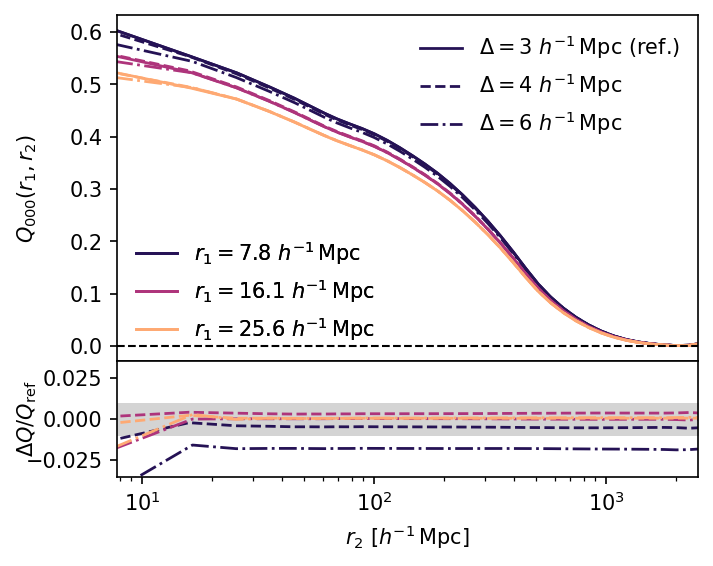

In [5]:
CMAP = plt.get_cmap('magma')
CMAP_OFFSET = 0.15

LW = 1.33
LINESTYLES = [
    '-',
    '--',
    '-.',
    ':',
]

NROW_MAIN = 3
NROW_DIFF = 1

RUNIT = r"$h^{-1}\,\mathrm{Mpc}$"
RPOW = 0

SLICE = slice(1, None)
RIND = [0, 1, 2]

nrow = NROW_MAIN + NROW_DIFF
ncol = len(MULTIPOLES)

fig = plt.figure(
    figsize=(5.*ncol, 1.*nrow),
    dpi=150,
)

ccycle = []
for mpole_idx, multipole in enumerate(MULTIPOLES):
    ax_main_ = plt.subplot2grid(
        (nrow, ncol), (0, mpole_idx), rowspan=NROW_MAIN
    )
    ax_diff_ = plt.subplot2grid(
        (nrow, ncol), (NROW_MAIN, mpole_idx), rowspan=NROW_DIFF,
        sharex=ax_main_
    )

    c_init = not ccycle

    r_ref_ = window_measurements[REF_TAG].r[multipole][SLICE]

    for idx, ridx in enumerate(RIND):
        r1_ = r_ref_[ridx]
        Qrow_ref_ = window_measurements[REF_TAG].Q[multipole][SLICE, SLICE][ridx]

        c_ = None if c_init else ccycle[idx]

        for idxtag_, (tag_, ls_) in enumerate(zip(CELLSAMP_TAGS, LINESTYLES)):
            tag_ = CELLSAMP_BASE.format(tag_)

            res_ = resolutions[tag_]

            r2_ = window_measurements[tag_].r[multipole][SLICE]
            Qrow_ = window_measurements[tag_].Q[multipole][SLICE, SLICE][ridx]

            label_ = []
            if (mpole_idx == 0) and (idx == 0):
                label_a = fr"$\Delta = {res_}$ {RUNIT}"
                if tag_ == REF_TAG: label_a += " (ref.)"
                label_.append(label_a)
            if (mpole_idx == len(MULTIPOLES) - 1) and (idxtag_ == 0):
                label_b = fr"$r_1 = {r1_:.1f}$ {RUNIT}"
                label_.append(label_b)
            if len(label_) == 0:
                label_ = None
            elif len(label_) == 1:
                label_ = label_.pop()

            if not isinstance(label_, list):
                if c_ is None:
                    line_ = ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=CMAP(ridx / len(RIND) + CMAP_OFFSET),
                        ls=ls_, lw=LW, label=label_,
                    )
                    c_ = line_[0].get_color()
                else:
                    ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=c_, ls=ls_, lw=LW, label=label_
                    )
            else:
                if c_ is None:
                    line_ = ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=CMAP(ridx/ len(RIND) + CMAP_OFFSET),
                        ls=ls_, lw=LW, label=label_[0],
                    )
                    line_ = ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=CMAP(ridx/ len(RIND) + CMAP_OFFSET),
                        ls=ls_, lw=LW, label=label_[1],
                    )
                    c_ = line_[0].get_color()
                else:
                    ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=c_, ls=ls_, lw=LW, label=label_[0]
                    )
                    ax_main_.semilogx(
                        r2_, r2_**RPOW * Qrow_,
                        c=c_, ls=ls_, lw=LW, label=label_[1]
                    )

            if tag_ != REF_TAG:
                dQrow_ = Qrow_ / np.interp(r2_, r_ref_, Qrow_ref_) - 1.
                ax_diff_.semilogx(
                    r2_, dQrow_,
                    c=c_, ls=ls_, lw=LW
                )

    ax_main_.axhline(0., c='k', ls='--', lw=1.)

    ax_diff_.fill_between(
        r_ref_, -0.01, +0.01,
        facecolor='0.33', edgecolor='0.33', lw=0., alpha=.25,
    )

    ax_diff_.set_xmargin(0.001)
    ax_diff_.set_xlim(7.8, 2500.)
    if mpole_idx == 0:
        ax_diff_.set_ylim(-0.035, 0.035)
    else:
        ax_diff_.set_ylim(-0.075, 0.075)

    ax_main_.tick_params(labelbottom=False)
    if RPOW == 0:
        ax_main_.set_ylabel(
            fr"$Q_{{{multipole.abstr}}}(r_1, r_2)$"
        )
    else:
        ax_main_.set_ylabel(
            fr"$r_2^{{{RPOW}}} Q_{{{multipole.abstr}}}(r_1, r_2)$"
        )
    ax_main_.get_yaxis().set_label_coords(-0.135, 0.5)

    ax_diff_.set_ylabel(r"$\Delta Q / Q_\mathrm{ref}$")
    ax_diff_.set_xlabel(fr"$r_2$ [{RUNIT}]")
    ax_diff_.get_yaxis().set_label_coords(-0.135, 0.5)

    handles, labels = ax_main_.get_legend_handles_labels()

    handles_a = [handles[idx] for idx in [0, 2, 3]]
    labels_a = [labels[idx] for idx in [0, 2, 3]]
    handles_b = [handles[idx] for idx in [1, 4, 5]]
    labels_b = [labels[idx] for idx in [1, 4, 5]]

    legend_a = ax_main_.legend(
        handles_a, labels_a, loc='upper right', frameon=False
    )
    legend_b = ax_main_.legend(
        handles_b, labels_b, loc='lower left', frameon=False
    )

    ax_main_.add_artist(legend_a)
    ax_main_.add_artist(legend_b)

plt.subplots_adjust(hspace=0)

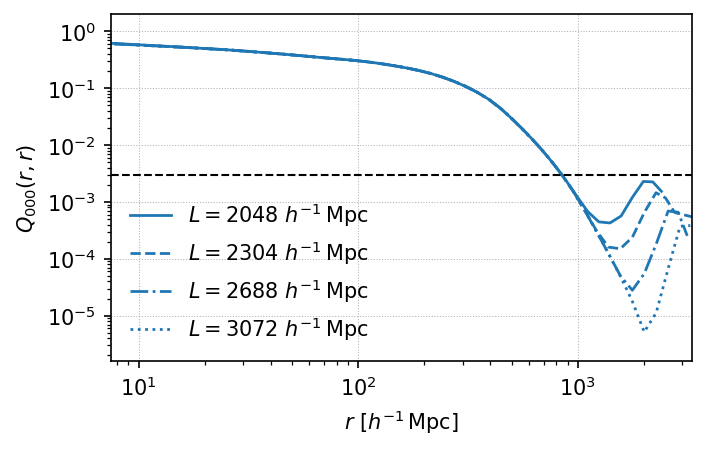

In [6]:
LW = 1.33
LINESTYLES = [
    '-',
    '--',
    '-.',
    ':',
]

NROW_MAIN = 3
NROW_DIFF = 0

RUNIT = r"$h^{-1}\,\mathrm{Mpc}$"
RPOW = 0

SLICE = slice(1, None)

nrow = NROW_MAIN + NROW_DIFF
ncol = len(MULTIPOLES)

fig = plt.figure(
    figsize=(5.*ncol, 1.*nrow),
    dpi=150,
)

for mpole_idx, multipole in enumerate(MULTIPOLES):
    ax_main_ = plt.subplot2grid(
        (nrow, ncol), (0, mpole_idx), rowspan=NROW_MAIN
    )
    if NROW_DIFF > 0:
        ax_ratio_ = plt.subplot2grid(
            (nrow, ncol), (NROW_MAIN, mpole_idx), rowspan=NROW_DIFF,
            sharex=ax_main_
        )

    c_ = None

    r_ref_ = window_measurements[REF_TAG].r[multipole][SLICE]

    Qdiag_ref_ = window_measurements[REF_TAG].Q_diag[multipole][SLICE]

    for idxtag_, (tag_, ls_) in enumerate(zip(BBOXSAMP_TAGS, LINESTYLES)):
        tag_ = BBOXSAMP_BASE.format(tag_)

        boxsize_ = boxsizes[tag_]

        r_ = window_measurements[tag_].r[multipole][SLICE]
        Qdiag_ = window_measurements[tag_].Q_diag[multipole][SLICE]

        label_ = None
        if mpole_idx == 0:
            label_ = fr"$L = {boxsize_}$ {RUNIT}"

        if c_ is None:
            line_ = ax_main_.semilogy(
                r_, r_**RPOW * Qdiag_,
                ls=ls_, lw=LW, label=label_,
            )
            c_ = line_[0].get_color()
        else:
            ax_main_.semilogx(
                r_, r_**RPOW * Qdiag_,
                c=c_, ls=ls_, lw=LW, label=label_
            )

        if (tag_ != REF_TAG) and (NROW_DIFF > 0):
            dQdiag_ = Qdiag_ / np.amax(Qdiag_ref_)
            ax_ratio_.loglog(
                r_, dQdiag_,
                c=c_, ls=ls_, lw=LW
            )

    ax_main_.axhline(5.e-3 * np.amax(Qdiag_ref_), c='k', ls='--', lw=1.)
    ax_main_.grid(True, which='major', ls=':', lw=0.5)

    ax_main_.set_xmargin(0.)
    ax_main_.set_ymargin(0.1)
    if NROW_DIFF > 0:
        ax_ratio_.set_ymargin(0.1)

    if RPOW == 0:
        ax_main_.set_ylabel(fr"$Q_{{{multipole.abstr}}}(r, r)$")
    else:
        ax_main_.set_ylabel(fr"$r^{{{RPOW}}} Q_{{{multipole.abstr}}}(r, r)$")

    if NROW_DIFF > 0:
        ax_ratio_.set_ylabel(r"$Q / Q_\mathrm{max}$")
        ax_ratio_.set_xlabel(fr"$r$ [{RUNIT}]")
    else:
        ax_main_.set_xlabel(fr"$r$ [{RUNIT}]")

    if mpole_idx == 0:
        ax_main_.legend(frameon=False)

plt.subplots_adjust(hspace=0)